In [1]:
import nltk
import pandas as pd
import os
import re
import pickle
from nltk import FreqDist
import numpy as np
import google_conf
from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)



from sklearn.metrics.pairwise import cosine_similarity

In [2]:
pop_data = google_conf.setup(sheet_url="https://docs.google.com/spreadsheets/d/1o8L0Rt4CzQ_DcYdaKgCdige4nJs0sydlTGiMBSstQtc/edit?usp=sharing", service_account_path="../../ServiceAccountsKey.json")

In [3]:
articles_metadata = pd.read_json("../data/article_metadata.json")
articles_metadata.head(5)

pop_id  year                 authors                            journal  \
0       0  2011              Bos et al.            Political Communication   
1       1  2019         Blassnig et al.            Political Communication   
2       2  2017                Caramani  American Political Science Review   
3       3  2020  Wuttke,Schimpf, Schoen  American Political Science Review   
4       4  2014                   Treib  Journal of European Public Policy   

                                               title     type  \
0  How the Media Shape Perceptions of Right-Wing ...  article   
1  Hitting a Nerve: Populist News Articles Lead t...  article   
2  Will vs. Reason: The Populist and Technocratic...  article   
3  When the Whole Is Greater than the Sum of Its ...  article   
4  The voter says no, but nobody listens: causes ...  article   

                                            filepath  
0  Political Communication/2011 - Bos et al. - Ho...  
1  Political Communication/2019 - Blassing et al....  
2  American Political Science Review/2017 - Caram...  
3  American Political Science Review/2020 - Wuttk...  
4  Journal of European Public Policy/2014 - Treib...

In [4]:
popid_year_dict = dict(zip(articles_metadata["pop_id"], articles_metadata["year"]))

In [5]:
# generating a new working title
articles_metadata["working_title"] = articles_metadata.apply(lambda row: row["authors"] + " " + str(row["year"]), axis=1)

In [6]:
title_freqs_dict = dict([el for el in FreqDist(articles_metadata["working_title"]).items() if el[1] > 1])
title_freqs_dict

{'Schmidt 2019': 2,
 'Rooduijn 2018': 2,
 'Grzymala-Busse 2019': 4,
 'Marcos-Marne et al. 2020': 2,
 'Mudde 2014': 2,
 'Kriesi 2020': 2,
 'Rooduijn 2014': 2,
 'Jones 2019': 2}

In [7]:
letters = ["a", "b", "c", "d", "e"]
met = []
new_titles = []
for title in articles_metadata["working_title"]:
    if title in title_freqs_dict.keys():
        for n in range(title_freqs_dict[title]):
            letter = letters[n]
            title_letter = title + letter
            if title_letter not in met:
                new_titles.append(title_letter)
                met.append(title_letter)
                break
    else:
        new_titles.append(title)


In [8]:
articles_metadata["working_title"] = new_titles

In [9]:
popid_title_dict = dict(zip(articles_metadata["pop_id"], articles_metadata["working_title"]))

In [10]:
poptypes_df = pd.read_csv("../data/poptypes_df.csv")
poptypes_df["variants"] = poptypes_df["variants"].apply(eval)
poptypes_df

Unnamed: 0        poptype  \
0           0     right-wing   
1           1      left-wing   
2           2    nationalist   
3           6  authoritatian   
4           8   exclusionary   
5           4        radical   
6           3       nativist   
7           7   inclusionary   
8           9     neoliberal   
9           5       moderate   

                                            variants  count  
0  [right-wing, right, right-, rightwe, radical-r...   2094  
1  [left-wing, left, left-, leftist, radical-left...    652  
2  [nationalism, nationalist, national, nation, e...    260  
3                  [authoritarian, authoritarianism]    157  
4  [exclusionary, exclusion, exclusive, exclusive...    116  
5                   [radical, radicalism, radically]    115  
6                               [nativism, nativist]     74  
7               [inclusionary, inclusive, inclusion]     67  
8           [neoliberal, neo-liberal, neoliberalism]     65  
9                             [moderate, moderately]     44

In [11]:
poptypes_dict = dict(zip(poptypes_df["poptype"], poptypes_df["variants"]))
poptypes_dict

{'right-wing': ['right-wing',
  'right',
  'right-',
  'rightwe',
  'radical-right',
  'radical-right-wing',
  'far-right',
  'rightist',
  'right-leaning',
  'radicalright',
  'rightwing',
  'extreme-right',
  'farright'],
 'left-wing': ['left-wing',
  'left',
  'left-',
  'leftist',
  'radical-left',
  'leftwing',
  'left-leaning',
  'leftwe',
  'leftism',
  'center-left',
  'radicalleft'],
 'nationalist': ['nationalism',
  'nationalist',
  'national',
  'nation',
  'ethno-nationalist',
  'nationalistic',
  'neo-nationalism'],
 'authoritatian': ['authoritarian', 'authoritarianism'],
 'exclusionary': ['exclusionary',
  'exclusion',
  'exclusive',
  'exclusively',
  'exclusionist'],
 'radical': ['radical', 'radicalism', 'radically'],
 'nativist': ['nativism', 'nativist'],
 'inclusionary': ['inclusionary', 'inclusive', 'inclusion'],
 'neoliberal': ['neoliberal', 'neo-liberal', 'neoliberalism'],
 'moderate': ['moderate', 'moderately']}

In [12]:
poptypes = poptypes_df["poptype"].tolist()

# read the concordance data

In [13]:
path = "../data/large_data/populis_conc10_min/"
all_concs = []
for pop_id in articles_metadata["pop_id"]:
    filename = "populis_conc10_pop_id_{}.txt".format(str(pop_id))
    filepath = path + filename
    year = popid_year_dict[pop_id]
    title = popid_title_dict[pop_id]
    with open(filepath, "r") as f:
        lines = f.readlines()
    lines_splitted = [l.split() for l in lines]
    lines_splitted = [(conc, str(year), title) for conc in lines_splitted]
    all_concs.extend(lines_splitted)

In [14]:
len(all_concs)

39605

In [15]:
conc_lengths = [len(conc[0]) for conc in all_concs]
len([l for l in conc_lengths if l==21])

39199

In [16]:
concs_covered_types = []
for conc, year, title in all_concs:
    conc = [w for w in conc if w not in ["populist", "populism"]]
    covered_types = []
    for key in poptypes_dict.keys():
        if set(poptypes_dict[key]) & set(conc):
            covered_types.append(key)
            conc = [w for w in conc if w not in poptypes_dict[key]]
    concs_covered_types.append((conc, covered_types, year, title))

In [17]:
concs_covered_types[:10]

[(['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article'],
  ['right-wing'],
  '2011',
  'Bos et al. 2011'),
 (['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article',
   'view',
   'view',
   'relate',
   'article'],
  ['right-wing'],
  '2011',
  'Bos et al. 2011'),
 (['view',
   'view',
   'relate',
   'article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn'],
  ['right-wing'],
  '2011',
  'Bos et al. 2011'),
 (['article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn',
   'key',
   'electoral',
   'success'],
  ['right-wing'],
  '2011',
  'B

In [18]:
len([el for el in concs_covered_types if bool(el[1])]) # previously 12255

12793

In [19]:
len([el for el in concs_covered_types if len(el[1])==1])

7915

In [20]:
concs_labeled = [(el[0], el[1][0], el[2], el[3]) for el in concs_covered_types if len(el[1])==1]
len(concs_labeled)

7915

In [21]:
concs_labeled[:5]

[(['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article'],
  'right-wing',
  '2011',
  'Bos et al. 2011'),
 (['access',
   'use',
   'find',
   'print',
   'homepage',
   'cite',
   'article',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article',
   'view',
   'view',
   'relate',
   'article'],
  'right-wing',
  '2011',
  'Bos et al. 2011'),
 (['view',
   'view',
   'relate',
   'article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn'],
  'right-wing',
  '2011',
  'Bos et al. 2011'),
 (['article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'argue',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn',
   'key',
   'electoral',
   'success'],
  'right-wing',
  '2011',
  'Bos et al

In [22]:
with open("../data/concs_labeled_min.pickle", "wb") as f:
    pickle.dump(concs_labeled, f)

In [23]:
concs_labeled_df = pd.DataFrame(concs_labeled, columns=["conc", "type", "year", "title"])
concs_labeled_df.to_csv("concs_labeled_df")

# Technocratic populism exploration

In [21]:
concs_covered_types[0]

(['access',
  'use',
  'find',
  'print',
  'homepage',
  'cite',
  'article',
  'publish',
  'online',
  'submit',
  'article',
  'journal',
  'article'],
 ['right-wing'],
 '2011',
 'Bos et al. 2011')

In [62]:
all_concs[:3]

[(['access',
   'use',
   'find',
   'print',
   'homepage',
   'right-wing',
   'populist',
   'cite',
   'article',
   'right-wing',
   'populist',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article'],
  '2011',
  'Bos et al. 2011'),
 (['access',
   'use',
   'find',
   'print',
   'homepage',
   'right-wing',
   'populist',
   'cite',
   'article',
   'right-wing',
   'populist',
   'publish',
   'online',
   'submit',
   'article',
   'journal',
   'article',
   'view',
   'view',
   'relate',
   'article'],
  '2011',
  'Bos et al. 2011'),
 (['view',
   'view',
   'relate',
   'article',
   'cite',
   'article',
   'view',
   'cite',
   'article',
   'right-wing',
   'populist',
   'argue',
   'right-wing',
   'populist',
   'party',
   'leader',
   'dependent',
   'medium',
   'public',
   'image',
   'turn'],
  '2011',
  'Bos et al. 2011')]

In [63]:
technocratic_preceding_N = 0
for conc, year, title in all_concs:
    try:
        inx = [t[0] for t in enumerate(conc) if re.search("populis", t[1], re.IGNORECASE)][0]
        if conc[inx-1] == "technocratic":
            technocratic_preceding_N += 1
    except:
        pass


In [64]:
technocratic_preceding_N

25

In [57]:
concs_covered_types_tech = []
for conc_data in concs_covered_types:
    if conc_data[0] [9] == "technocratic":
    # if set(["technocratic"]) & set(conc_data[0]):
        #if len(conc_data[1]) == 0:
        concs_covered_types_tech.append((conc_data[0], "technocratic", conc_data[2], conc_data[3]))

In [50]:
concs_covered_types_tech = []
for conc_data in concs_covered_types:
    if set(["technocratic"]) & set(conc_data[0]):
        #if len(conc_data[1]) == 0:
            concs_covered_types_tech.append((conc_data[0], "technocratic", conc_data[2], conc_data[3]))

In [51]:
len(concs_covered_types_tech)

254

In [52]:
concs_covered_types_tech_df = pd.DataFrame(concs_covered_types_tech)
concs_covered_types_tech_df.rename(columns={0 : "conc", 1 : "poptype", 2 : "year", 3 : "title"}, inplace=True)
concs_covered_types_tech_df.head(10)

conc       poptype  year  \
0  [reason, article, compare, analytically, techn...  technocratic  2017   
1  [analytically, technocracy, alternative, form,...  technocratic  2017   
2  [require, voter, delegate, authority, leader, ...  technocratic  2017   
3  [bolivarian, clothe, party, like, die, note, t...  technocratic  2017   
4  [proportional, representation, party, structur...  technocratic  2017   
5  [party, capacity, foster, loyalty, party, repr...  technocratic  2017   
6  [view, competition, matter, party, over-respon...  technocratic  2017   
7  [limit, possibility, act, merely, managerial, ...  technocratic  2017   
8  [complexity, network, governance, consequently...  technocratic  2017   
9  [main, section, article, address, way, alterna...  technocratic  2017   

           title  
0  Caramani 2017  
1  Caramani 2017  
2  Caramani 2017  
3  Caramani 2017  
4  Caramani 2017  
5  Caramani 2017  
6  Caramani 2017  
7  Caramani 2017  
8  Caramani 2017  
9  Caramani 2017

In [53]:
concs_covered_types_tech_df[(concs_covered_types_tech_df["conc"].apply(lambda x: len(x)==20)) & (concs_covered_types_tech_df["conc"].apply(lambda x: x[9]=="technocratic"))]

conc       poptype  year  \
32   [follow, elitism, latent, class, analysis, ide...  technocratic  2020   
43   [form, sizable, group, country, study, ask, di...  technocratic  2020   
47   [source, lack, responsiveness, people, lack, r...  technocratic  2020   
55   [ordinary, people, second, goal, identify, pop...  technocratic  2020   
56   [superior, skill, knowledge, elite, scientific...  technocratic  2020   
61   [aim, identify, substantively, meaningful, gro...  technocratic  2020   
65   [triangular, relationship, allow, address, dir...  technocratic  2020   
67   [country, constitute, small, percentage, popul...  technocratic  2020   
78   [overall, ideology, provide, important, distin...  technocratic  2020   
82   [class, analysis, article, investigate, hetero...  technocratic  2020   
138  [debate, compromise, actor, consider, legitima...  technocratic  2019   
139  [minority, separation, power, checks-and-balan...  technocratic  2019   
145  [anti-party, anti-political, discourse, suppre...  technocratic  2019   
146  [functional, constraint, word, base, different...  technocratic  2019   
148  [common, discursive, formula, unique, italian,...  technocratic  2019   

                      title  
32   Bertsou, Caramani 2020  
43   Bertsou, Caramani 2020  
47   Bertsou, Caramani 2020  
55   Bertsou, Caramani 2020  
56   Bertsou, Caramani 2020  
61   Bertsou, Caramani 2020  
65   Bertsou, Caramani 2020  
67   Bertsou, Caramani 2020  
78   Bertsou, Caramani 2020  
82   Bertsou, Caramani 2020  
138             Havlík 2019  
139             Havlík 2019  
145             Havlík 2019  
146             Havlík 2019  
148             Havlík 2019

Text(0.5, 1.0, 'technocratic (N=45)')

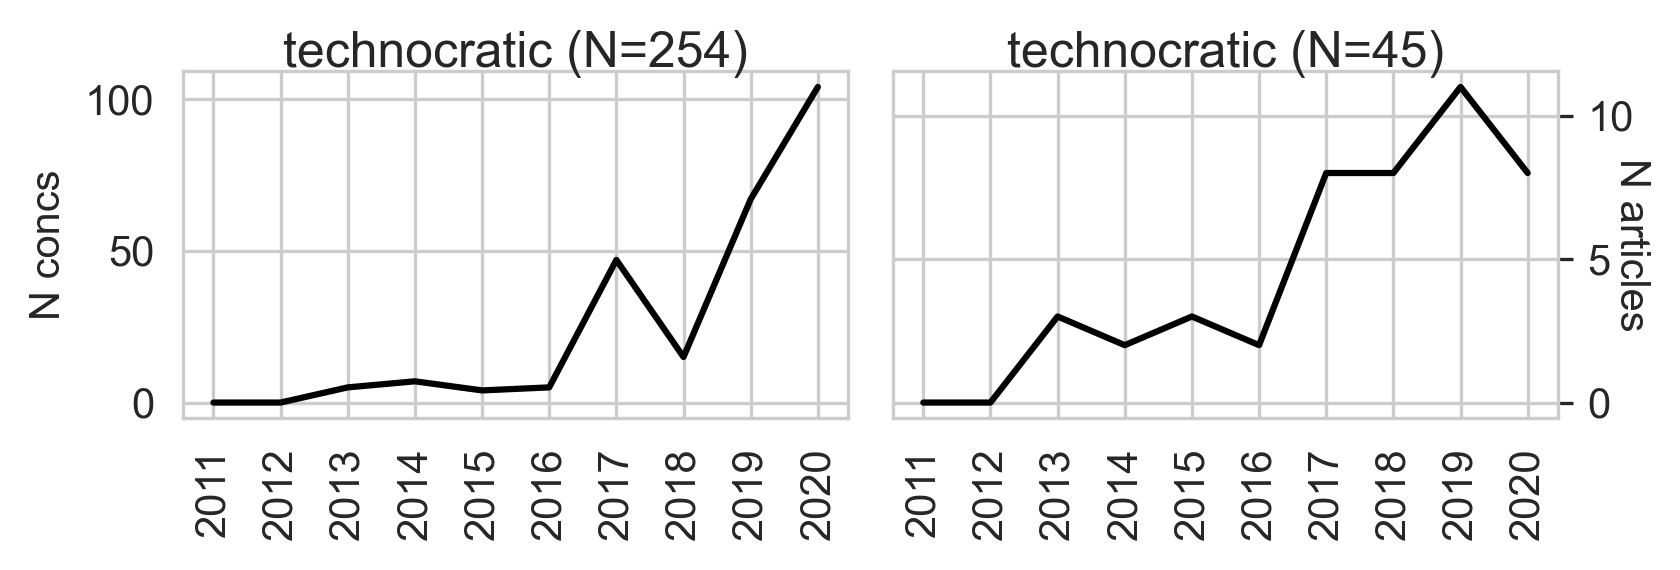

In [74]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(5.7, 2) ,tight_layout=True, dpi=300)
x = range(2011,2021)
y =[(concs_covered_types_tech_df["year"]==str(year)).sum() for year in x]
ax1.plot(x, y ,color="black")
ax1.set_xlabel("")
ax1.set_xticks(range(2011,2021))
ax1.set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
ax1.set_ylabel("N concs")
ax1.set_title("technocratic"  + " (N={})".format(str(len(concs_covered_types_tech_df))), pad=1)

y =[len(set(concs_covered_types_tech_df[concs_covered_types_tech_df["year"]==str(year)]["title"])) for year in x]
ax2.plot(x, y ,color="black")
ax2.set_xlabel("")
ax2.set_xticks(range(2011,2021))
ax2.set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("N articles", rotation=270)
ax2.set_title("technocratic" + " (N={})".format(str(len(set(concs_covered_types_tech_df["title"])))), pad=1)


In [75]:
fig.savefig("../figures/technocratic_counts+articles_years.png")

# Overview of labeled concordances

In [25]:
concs_labeled_df

conc         type  year  \
0     [access, use, find, print, homepage, cite, art...   right-wing  2011   
1     [access, use, find, print, homepage, cite, art...   right-wing  2011   
2     [view, view, relate, article, cite, article, v...   right-wing  2011   
3     [article, cite, article, view, cite, article, ...   right-wing  2011   
4     [success, study, test, assumption, compare, ef...   right-wing  2011   
...                                                 ...          ...   ...   
7910  [contemporary, link, rise, party, european, co...   neoliberal  2015   
7911  [learn, lesson, ideology, style, rhetoric, ide...   neoliberal  2015   
7912  [japanese, discuss, article, need, identify, c...   neoliberal  2015   
7913  [japanese, politic, politic, instance, diverse...   neoliberal  2015   
7914  [learn, need, remember, japanese, politician, ...  nationalist  2015   

                title  
0     Bos et al. 2011  
1     Bos et al. 2011  
2     Bos et al. 2011  
3     Bos et al. 2011  
4     Bos et al. 2011  
...               ...  
7910    Lindgren 2015  
7911    Lindgren 2015  
7912    Lindgren 2015  
7913    Lindgren 2015  
7914    Lindgren 2015  

[7915 rows x 4 columns]

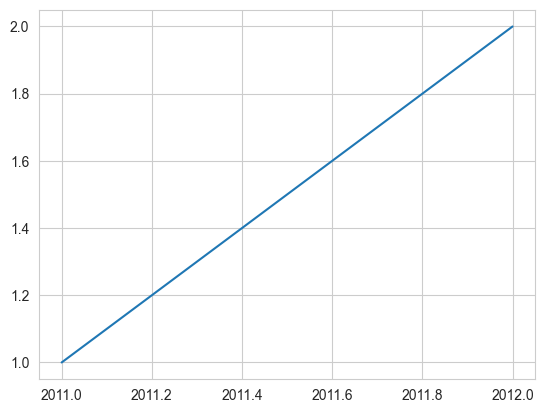

In [106]:
plt.plot([2011,2012], [1,2])


In [120]:
poptype = "nativist"
poptype_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
x = range(2011,2021)
y =[(poptype_df["year"]==str(year)).sum() for year in range(2011,2021)]

[0, 0, 0, 3, 6, 20, 56, 62, 26, 16]

Text(0.5, 0, 'year')

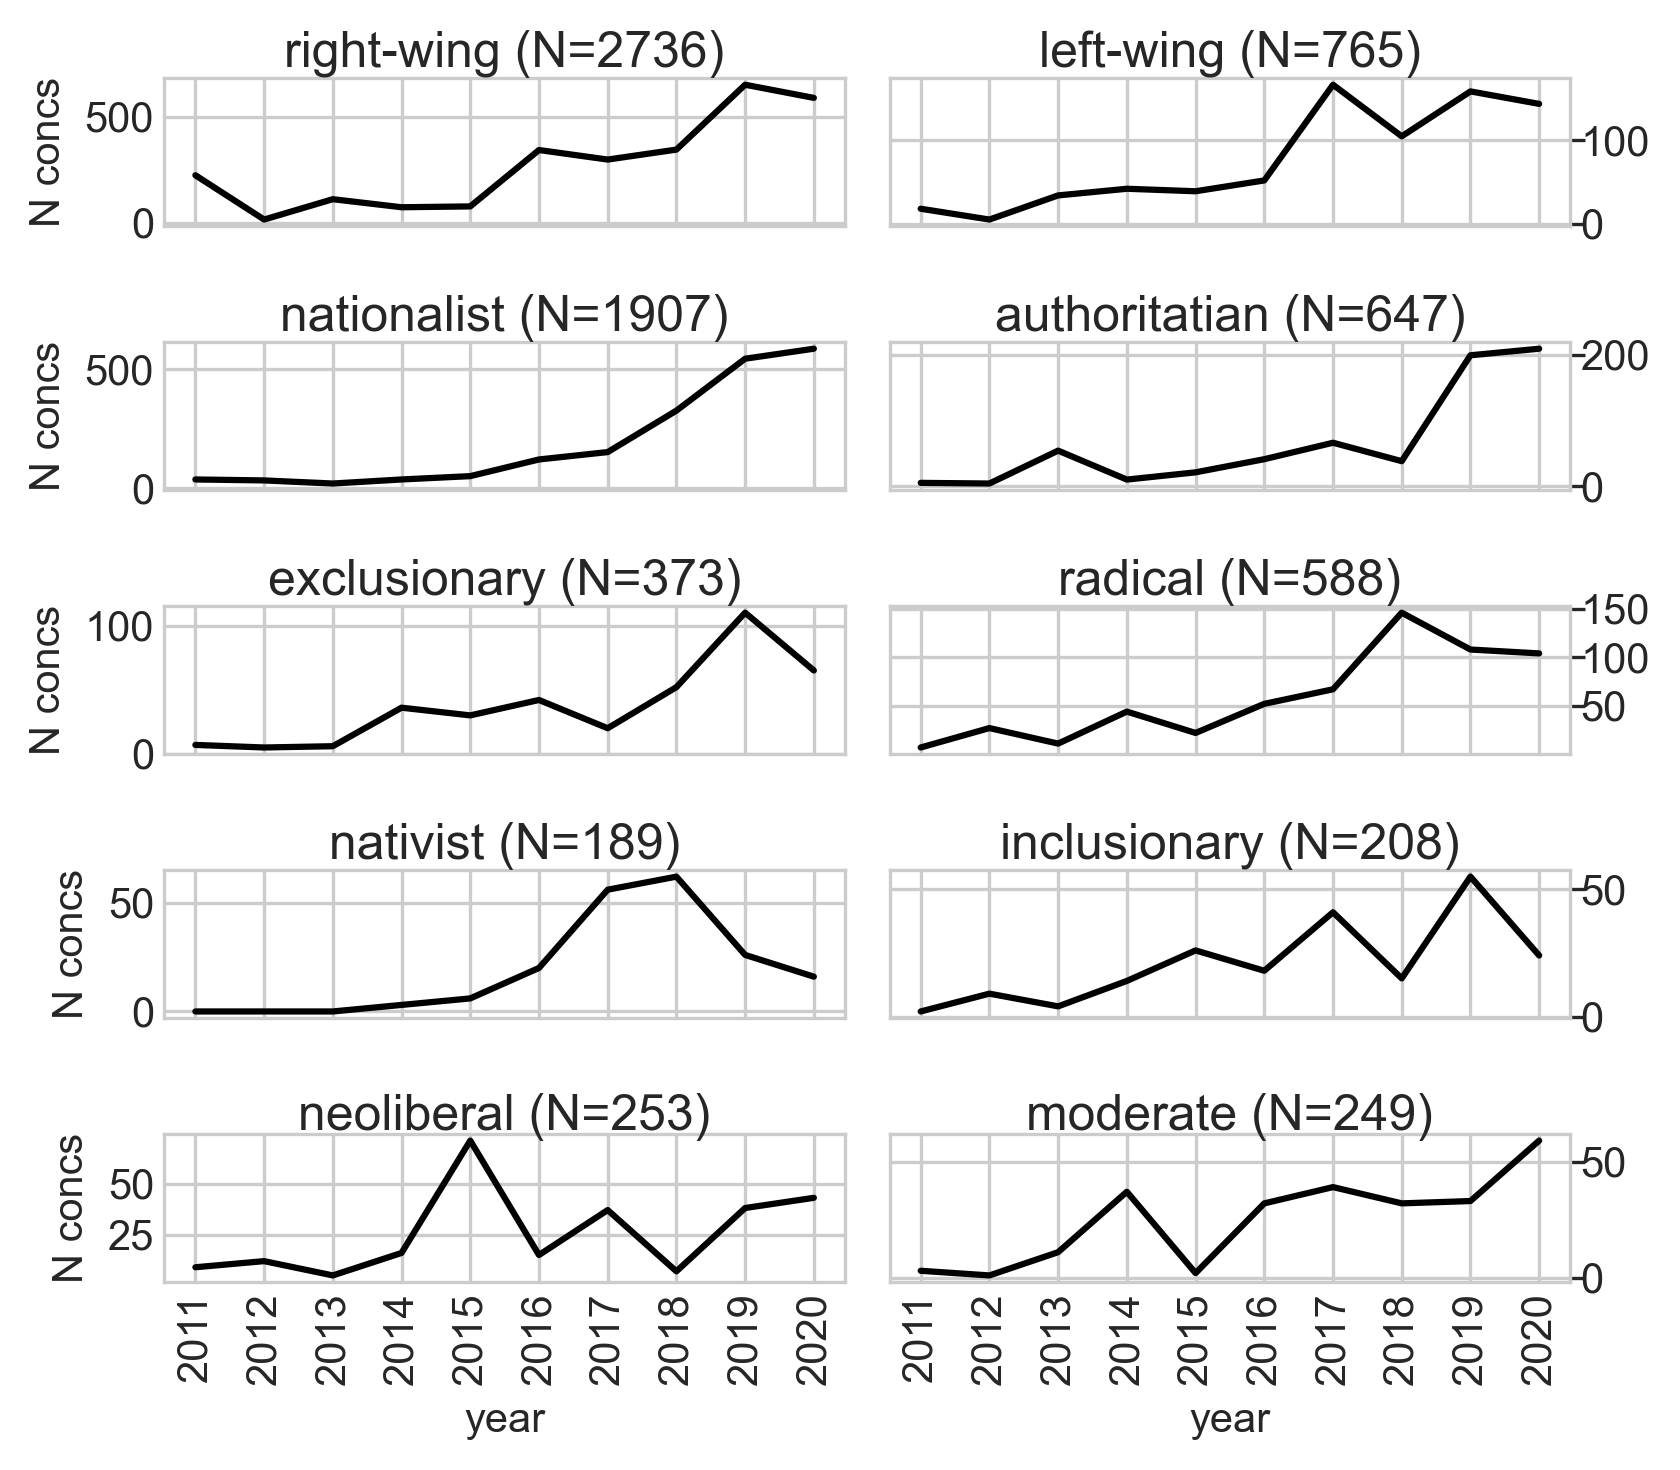

In [135]:
fig, axs = plt.subplots(5,2, figsize=(5.7, 5) ,tight_layout=True, dpi=300)

for poptype, ax, n in zip(poptypes, axs.ravel(), range(len(poptypes))):
    poptype_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    x = range(2011,2021)
    y =[(poptype_df["year"]==str(year)).sum() for year in x]
    ax.plot(x, y ,color="black")
    ax.set_xlabel("")
    ax.set_xticks(range(2011,2021))
    ax.set_xticklabels([])
    if (n % 2) == 0:
        ax.set_ylabel("N concs")
    else:
        ax.yaxis.tick_right()
    ax.set_title(poptype + " (N={})".format(str(len(poptype_df))), pad=1)
    ax.tick_params(axis='both', which='major', pad=-1)



axs[4,0].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,0].set_xlabel("year")

axs[4,1].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,1].set_xlabel("year")

In [136]:
fig.savefig("../figures/poptypes_counts_years.png")

Text(0.5, 0, 'year')

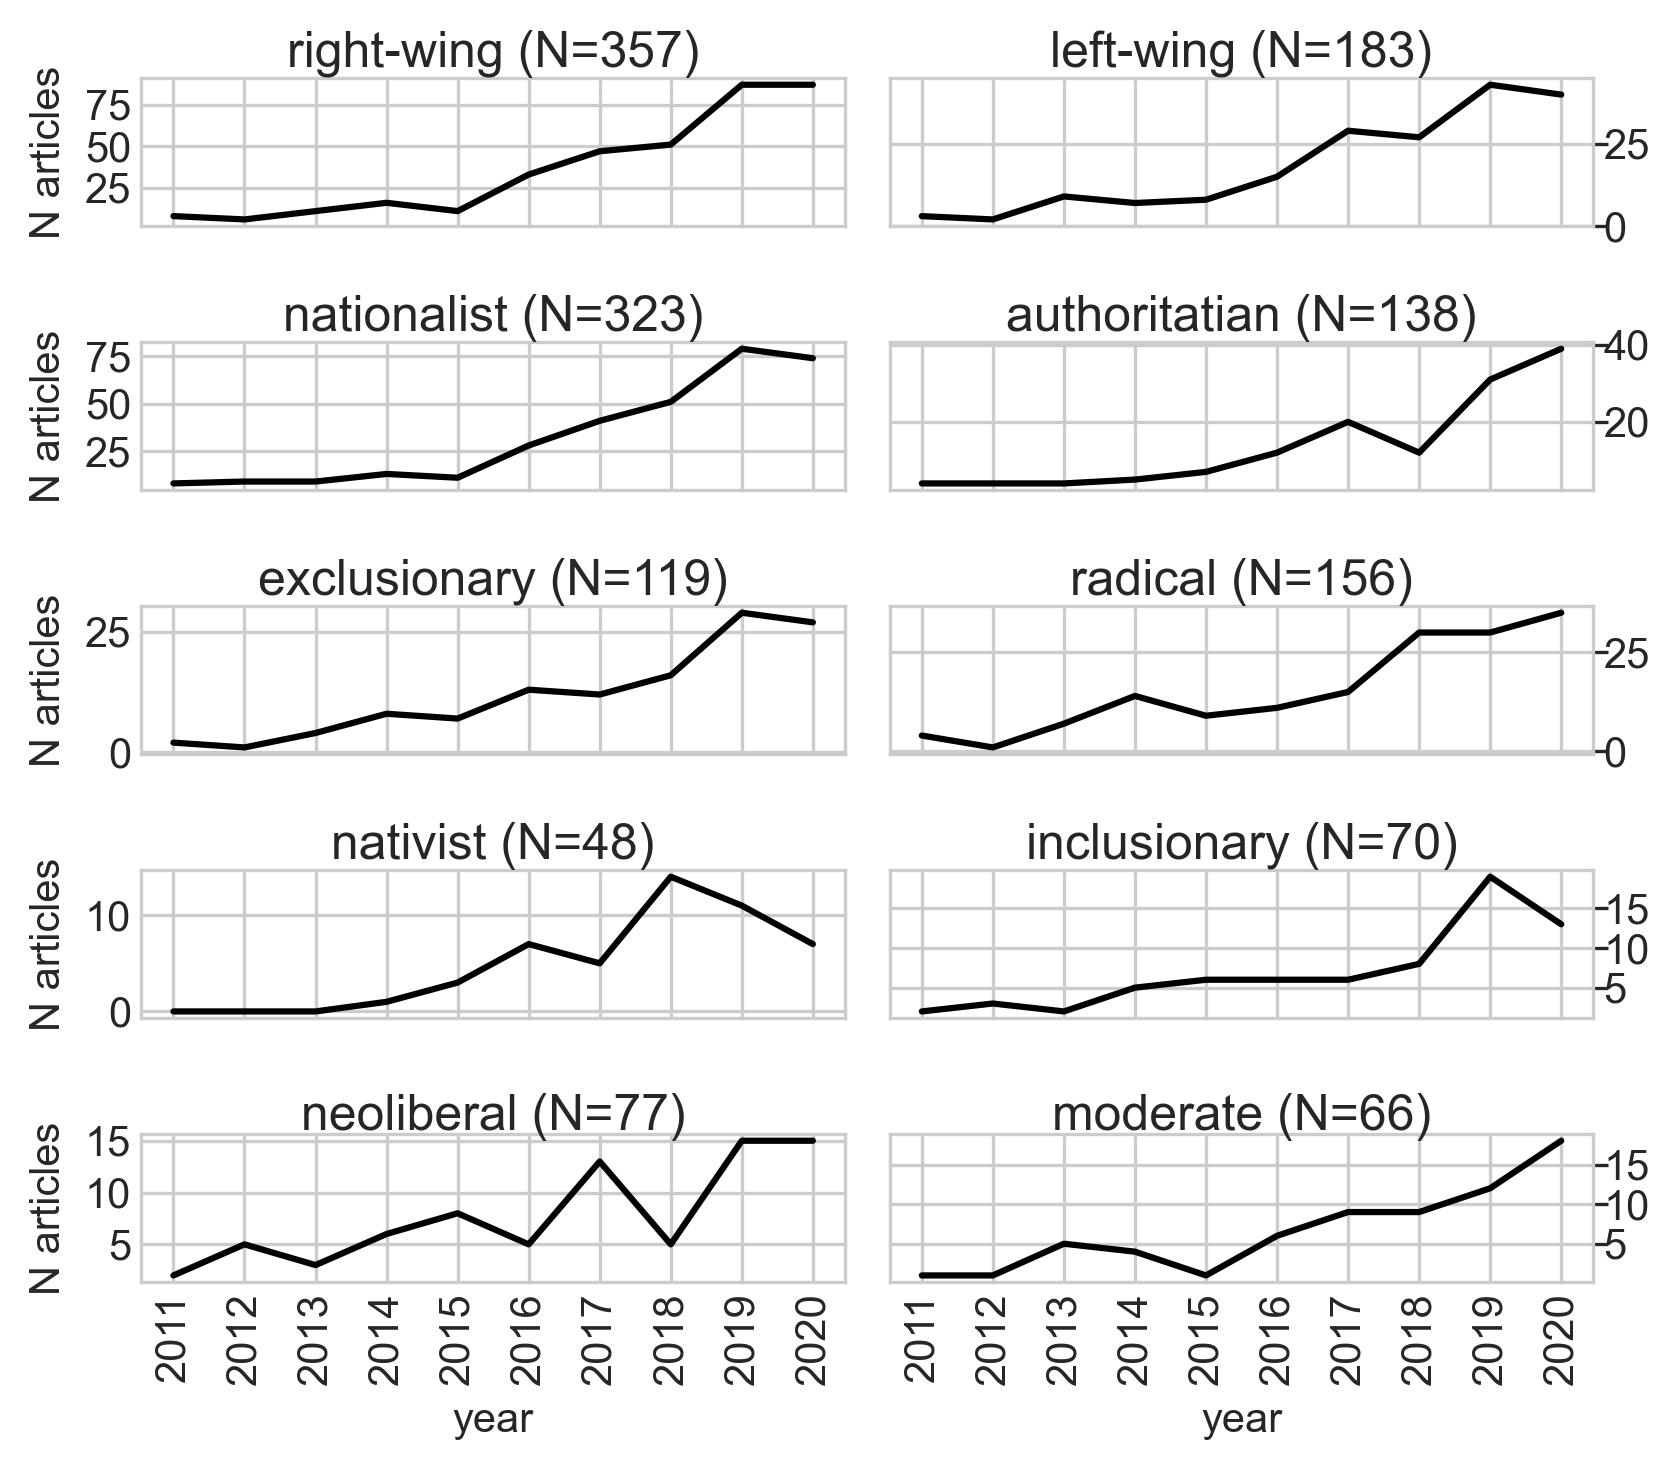

In [133]:
fig, axs = plt.subplots(5,2, figsize=(5.7, 5) ,tight_layout=True, dpi=300)

for poptype, ax, n in zip(poptypes, axs.ravel(), range(len(poptypes))):
    poptype_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    x = range(2011,2021)
    y =[len(set(poptype_df[poptype_df["year"]==str(year)]["title"])) for year in x]
    ax.plot(x, y ,color="black")
    ax.set_xlabel("")
    ax.set_xticks(range(2011,2021))
    ax.set_xticklabels([])
    if (n % 2) == 0:
        ax.set_ylabel("N articles")
    else:
        ax.yaxis.tick_right()
    ax.set_title(poptype + " (N={})".format(str(len(set(poptype_df["title"])))), pad=1)
    ax.tick_params(axis='both', which='major', pad=-1)



axs[4,0].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,0].set_xlabel("year")

axs[4,1].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,1].set_xlabel("year")

In [134]:
fig.savefig("../figures/poptypes_n_articles_years.png")


In [ ]:
len(set(poptype_df["title"]))

In [93]:
poptype_df_grouped = poptype_df.groupby("year").size()
poptype_df_grouped

year
2014     3
2015     6
2016    20
2017    56
2018    62
2019    26
2020    16
dtype: int64

In [96]:
poptype_df_grouped

year
2014     3
2015     6
2016    20
2017    56
2018    62
2019    26
2020    16
dtype: int64

In [84]:
doc_counts = [len(set(poptype_df[poptype_df["year"]==str(year)]["title"])) for year in range(2011, 2021)]

In [85]:
doc_counts

[1, 1, 5, 4, 1, 6, 9, 9, 12, 18]

In [ ]:
fig, axs = plt.subplots(5,2, figsize=(5.7, 5) ,tight_layout=True, dpi=300)

for poptype, ax, n in zip(poptypes, axs.ravel(), range(len(poptypes))):
    poptype_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    poptype_df  .plot(ax=ax, color="black")
    ax.set_xlabel("")
    ax.set_xlim(-0.5,9.5)
    ax.set_xticks(range(10))
    ax.set_xticklabels([])
    if (n % 2) == 0:
        ax.set_ylabel("count")
    else:
        ax.yaxis.tick_right()
    ax.set_title(poptype + " (N={})".format(str(len(poptype_df))), pad=1)
    ax.tick_params(axis='both', which='major', pad=-1)

axs[4,0].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,0].set_xlabel("year")

axs[4,1].set_xticklabels([str(y) for y in range(2011,2021)], rotation=90)
axs[4,1].set_xlabel("year")

# Word explorations

In [69]:
labeled_freqs = nltk.FreqDist([w for conc in concs_labeled_df["conc"] for w in conc]).most_common()
len(labeled_freqs)

9724

In [71]:
to_remove = [tup[0] for tup in labeled_freqs][:5]
to_remove

['party', 'political', 'people', 'democracy', 'politic']

In [44]:
poptype = "left-wing"
subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]

def get_freqs_formatted(subset_df, n=100):
    subset_concs_flatten = [w for conc in subset_df["conc"] for w in conc if w not in ["populist", "populism"]]
    total = len(subset_concs_flatten)
    #freqdist_N = [(w + " ({})".format(str(np.round(count/total, 4)))) for w, count in FreqDist(subset_concs_flatten).most_common(n)]
    freqdist_N = [w for w, count in FreqDist(subset_concs_flatten).most_common(n)]
    return freqdist_N

In [45]:
poptypes_wordfreqs_dict = {}
for poptype in poptypes:
    subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    poptypes_wordfreqs_dict[poptype] = get_freqs_formatted(subset_df, n=100)

In [46]:
poptypes_wordfreqs_df = pd.DataFrame(poptypes_wordfreqs_dict)

In [47]:
poptypes_wordfreqs_df.head(10)

right-wing  left-wing nationalist authoritatian exclusionary     radical  \
0      party      party       party     democracy        party       party   
1  political  political      people     political    political   political   
2     leader    support   political        regime       people   democracy   
3     people   economic     politic         party         case      people   
4    support        new   discourse    democratic      politic     politic   
5  democracy     policy       elite   competitive        elite        case   
6     effect     people       level        leader    democracy         new   
7      study       case   different         power    discourse  democratic   
8      voter   attitude        case       politic     movement    analysis   
9   attitude    politic  government        people        focus    movement   

       nativist inclusionary    neoliberal    moderate  
0         party        party     political       party  
1        people    political         party      effect  
2      movement   democratic      economic    attitude  
3     political       people        policy       level  
4      ideology          way       politic  successful  
5  mobilization    democracy         state        case  
6      economic    discourse        social   political  
7         study     european      ideology       actor  
8       support        group  contemporary     support  
9          case       effect      japanese  government

In [48]:
poptypes_wordfreqs_df.to_csv("../data/poptypes_wordfreqs_df.csv")

In [49]:
google_conf.set_with_dataframe(pop_data.add_worksheet("poptypes_wordfreqs_df", 1,1), poptypes_wordfreqs_df)

In [72]:
poptype = "left-wing"
subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]

def get_freqs_vals(subset_df):
    subset_concs_flatten = [w for conc in subset_df["conc"] for w in conc if w not in ["populist", "populism"]]
    total = len(subset_concs_flatten)
    freqdist_N = dict([(w, count/total) for w, count in FreqDist(subset_concs_flatten).most_common()])
    # freqdist_N = [w for w, count in FreqDist(subset_concs_flatten).most_common(n)]
    return freqdist_N

In [73]:
get_freqs_vals(subset_df)

{'party': 0.031091462530801566,
 'political': 0.012538048992607624,
 'support': 0.008117118422959849,
 'economic': 0.007754747064791999,
 'new': 0.006667632990288447,
 'policy': 0.006015364545586317,
 'people': 0.005580518915784896,
 'case': 0.005508044644151326,
 'attitude': 0.005435570372517756,
 'politic': 0.005218147557617046,
 'government': 0.004493404841281345,
 'social': 0.004275982026380635,
 'form': 0.004203507754747065,
 'democracy': 0.004203507754747065,
 'voter': 0.003986084939846354,
 'effect': 0.003986084939846354,
 'election': 0.003913610668212784,
 'leader': 0.0038411363965792145,
 'position': 0.0037686621249456444,
 'discourse': 0.003623713581678504,
 'study': 0.003551239310044934,
 'european': 0.003478765038411364,
 'country': 0.003406290766777794,
 'movement': 0.003406290766777794,
 'ideological': 0.003406290766777794,
 'ideology': 0.003406290766777794,
 'focus': 0.0033338164951442237,
 'rise': 0.0033338164951442237,
 'vote': 0.0033338164951442237,
 'crisis': 0.00318

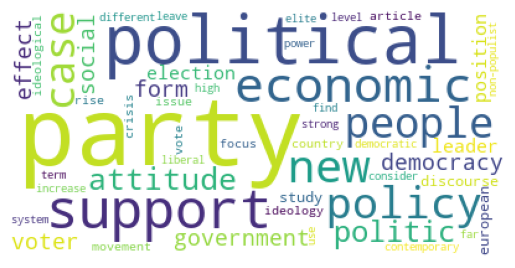

In [74]:
wc = WordCloud(max_words=50, background_color="white", relative_scaling=0.5)
wc.generate_from_frequencies(get_freqs_vals(subset_df))
plt.imshow(wc)  # , interpolation="bilinear")
plt.axis("off")
plt.show()

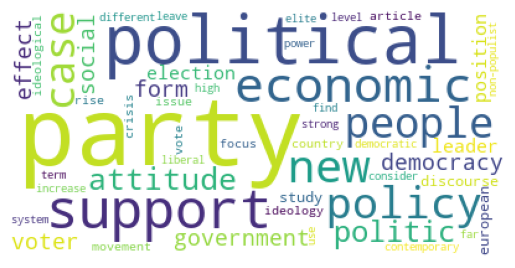

In [75]:
plt.imshow(wc) # , interpolation="bilinear")
plt.axis("off")
plt.show()

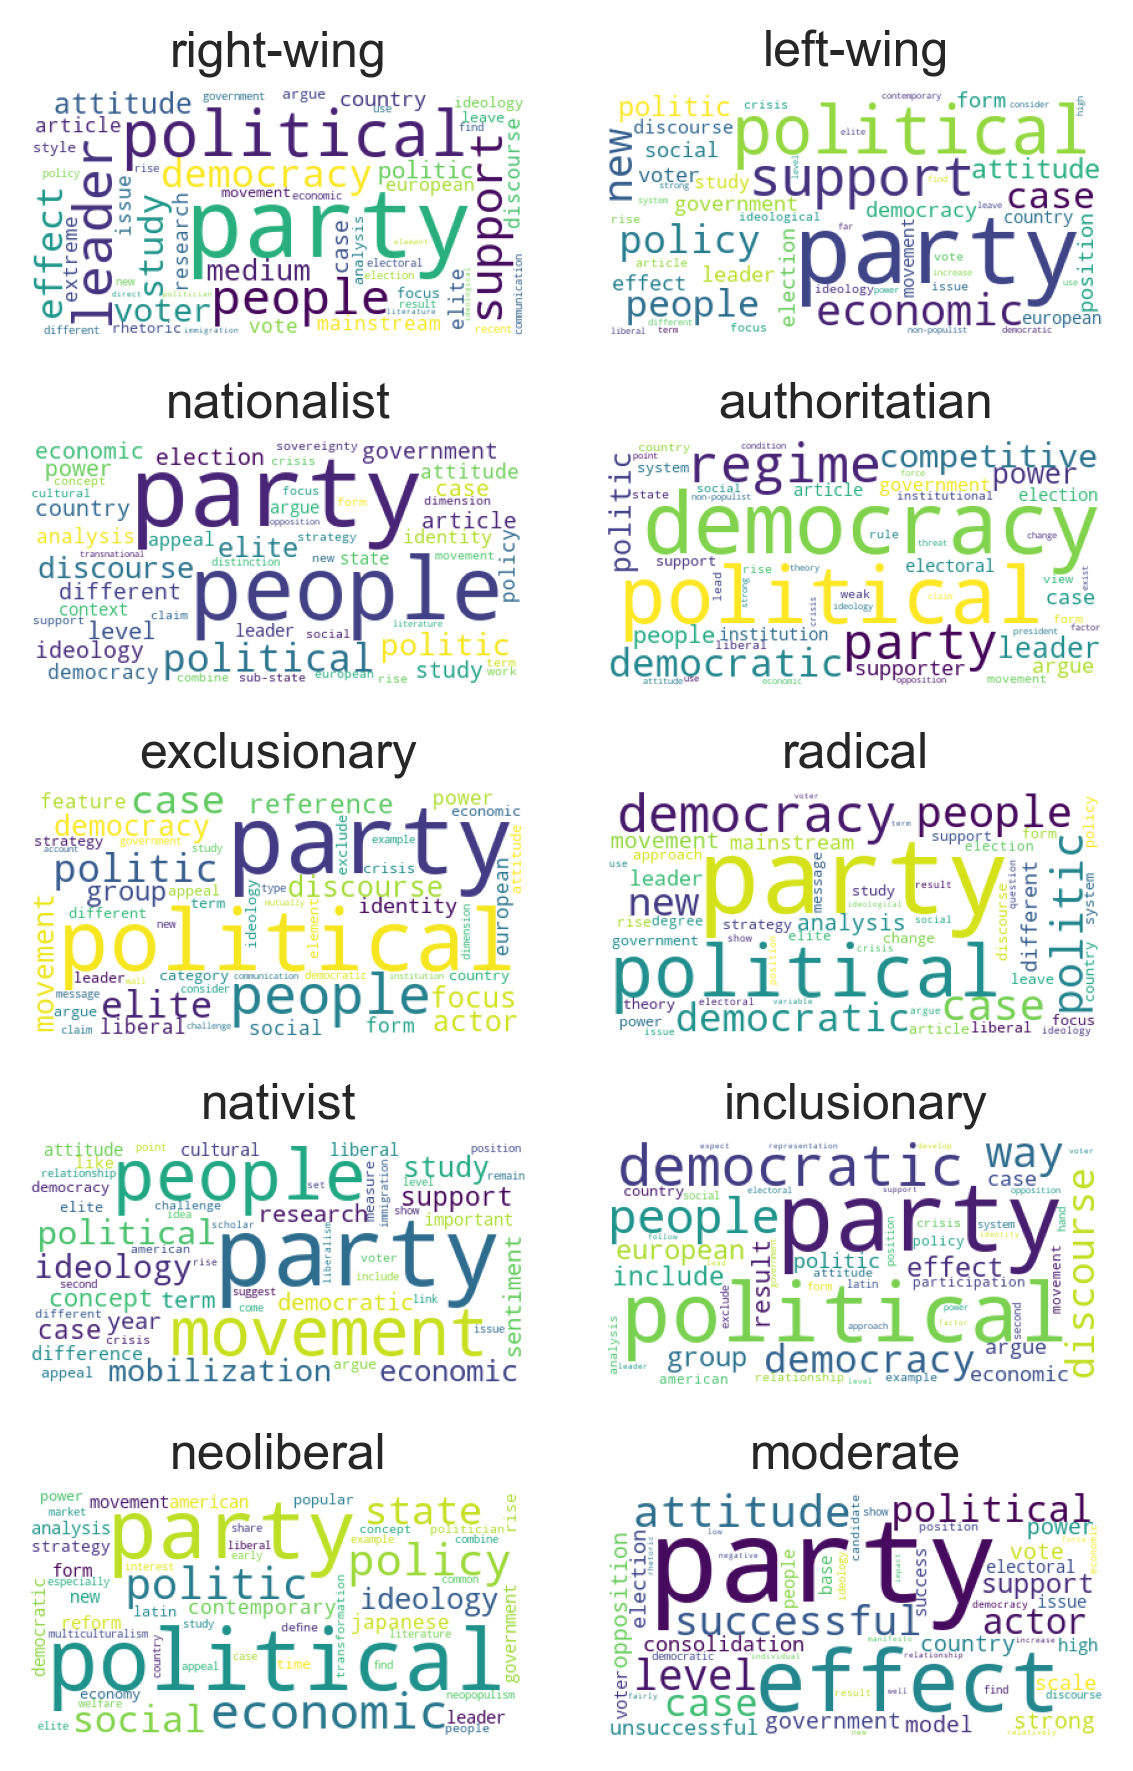

In [76]:
fig, axs = plt.subplots(5,2, figsize=(4,6), dpi=300,tight_layout=True)
for ax, poptype in zip(axs.ravel(), poptypes):
    subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    wc = WordCloud(max_words=50, background_color="white")
    wc.generate_from_frequencies(get_freqs_vals(subset_df))
    ax.imshow(wc) # , interpolation="bilinear")
    ax.axis("off")
    ax.set_title(poptype)

In [77]:
freqs_vals_dict = {}
for poptype in poptypes:
    subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    freqs_vals_dict[poptype] = get_freqs_vals(subset_df)
freqs_vals_df = pd.DataFrame(freqs_vals_dict).fillna(0)
freqs_vals_df[1500:1510]

right-wing  left-wing  nationalist  authoritatian  \
paradoxical      0.000122   0.000000     0.000000       0.000000   
constituent      0.000122   0.000290     0.000146       0.001720   
classiﬁcation    0.000122   0.000000     0.000146       0.000086   
heterogeneity    0.000122   0.000000     0.000088       0.000086   
teach            0.000122   0.000000     0.000029       0.000258   
rightly          0.000122   0.000000     0.000058       0.000086   
grassroot        0.000122   0.000145     0.000058       0.000430   
aﬃnity           0.000122   0.000000     0.000058       0.000000   
extraordinary    0.000102   0.000000     0.000175       0.000172   
adhere           0.000102   0.000072     0.000175       0.000000   

               exclusionary   radical  nativist  inclusionary  neoliberal  \
paradoxical        0.000000  0.000094       0.0      0.000000         0.0   
constituent        0.000149  0.000657       0.0      0.000000         0.0   
classiﬁcation      0.000149  0.000094       0.0      0.000000         0.0   
heterogeneity      0.000000  0.000094       0.0      0.000264         0.0   
teach              0.000000  0.000000       0.0      0.000000         0.0   
rightly            0.000000  0.000188       0.0      0.000000         0.0   
grassroot          0.000000  0.000094       0.0      0.000264         0.0   
aﬃnity             0.000000  0.000000       0.0      0.000000         0.0   
extraordinary      0.000000  0.000094       0.0      0.000264         0.0   
adhere             0.000000  0.000281       0.0      0.000000         0.0   

               moderate  
paradoxical    0.000000  
constituent    0.000455  
classiﬁcation  0.000000  
heterogeneity  0.000455  
teach          0.000000  
rightly        0.000000  
grassroot      0.000000  
aﬃnity         0.000000  
extraordinary  0.000000  
adhere         0.000000

In [78]:
freqs_cossim = pd.DataFrame(cosine_similarity(freqs_vals_df.T).round(2), columns=poptypes, index=poptypes)
freqs_cossim

right-wing  left-wing  nationalist  authoritatian  \
right-wing           1.00       0.92         0.83           0.66   
left-wing            0.92       1.00         0.84           0.67   
nationalist          0.83       0.84         1.00           0.72   
authoritatian        0.66       0.67         0.72           1.00   
exclusionary         0.81       0.81         0.87           0.68   
radical              0.92       0.91         0.83           0.70   
nativist             0.75       0.75         0.77           0.60   
inclusionary         0.80       0.82         0.81           0.70   
neoliberal           0.68       0.76         0.75           0.64   
moderate             0.82       0.80         0.68           0.52   

               exclusionary  radical  nativist  inclusionary  neoliberal  \
right-wing             0.81     0.92      0.75          0.80        0.68   
left-wing              0.81     0.91      0.75          0.82        0.76   
nationalist            0.87     0.83      0.77          0.81        0.75   
authoritatian          0.68     0.70      0.60          0.70        0.64   
exclusionary           1.00     0.82      0.74          0.80        0.70   
radical                0.82     1.00      0.74          0.82        0.72   
nativist               0.74     0.74      1.00          0.70        0.64   
inclusionary           0.80     0.82      0.70          1.00        0.71   
neoliberal             0.70     0.72      0.64          0.71        1.00   
moderate               0.65     0.77      0.63          0.70        0.53   

               moderate  
right-wing         0.82  
left-wing          0.80  
nationalist        0.68  
authoritatian      0.52  
exclusionary       0.65  
radical            0.77  
nativist           0.63  
inclusionary       0.70  
neoliberal         0.53  
moderate           1.00

# Weighted frequencies
(an alternative to tf-idf)

In [85]:
labeled_freqs = nltk.FreqDist([w for conc in concs_labeled_df["conc"] for w in conc]).most_common()
total_count = sum([tup[1] for tup in labeled_freqs])
labeled_freqs = [(tup[0], tup[1] / total_count) for tup in labeled_freqs]
labeled_freqs_dict = dict(labeled_freqs)

In [87]:
labeled_freqs_dict

{'party': 0.027207247763209725,
 'political': 0.012858027122840582,
 'people': 0.008595464520848573,
 'democracy': 0.006203927747453717,
 'politic': 0.005859265094817399,
 'leader': 0.0053035844915874176,
 'case': 0.004944853975578189,
 'support': 0.0049167182488323675,
 'discourse': 0.0043118001237971975,
 'attitude': 0.0041570536266951775,
 'economic': 0.00404451071971189,
 'elite': 0.004009341061279613,
 'effect': 0.00396713747116088,
 'study': 0.0039108660176692366,
 'country': 0.0038053570423724043,
 'government': 0.0037772213156265825,
 'movement': 0.003509931911541275,
 'article': 0.0034255247313038097,
 'ideology': 0.003411456867930899,
 'power': 0.003369253277812166,
 'policy': 0.0033481514827527997,
 'democratic': 0.003334083619379889,
 'different': 0.0032145067807101456,
 'analysis': 0.0031652692589049574,
 'voter': 0.0031230656687862247,
 'new': 0.0031160317370997693,
 'argue': 0.003108997805413314,
 'election': 0.00305272635192167,
 'european': 0.0028839119914467392,
 'lev

In [162]:
overall_freqs = freqs_vals_df.reset_index()["index"].apply(lambda x: labeled_freqs_dict[x])
freqs_vals_df["overall_freqs"]  = overall_freqs.round(6).tolist()

In [163]:
freqs_vals_df.sort_values("overall_freqs", ascending=False, inplace=True)

In [164]:
freqs_vals_df

right-wing  left-wing  nationalist  authoritatian  exclusionary  \
party           0.036862   0.031091     0.016901       0.010317      0.021346   
political       0.012226   0.012538     0.012260       0.013498      0.016271   
people          0.007776   0.005581     0.012931       0.005674      0.014032   
democracy       0.006327   0.004204     0.003561       0.016164      0.005523   
politic         0.004817   0.005218     0.007794       0.006448      0.006120   
...                  ...        ...          ...            ...           ...   
demobilizing    0.000000   0.000000     0.000029       0.000000      0.000000   
tacit           0.000000   0.000000     0.000029       0.000000      0.000000   
colonel         0.000000   0.000000     0.000029       0.000000      0.000000   
pueblo          0.000000   0.000000     0.000029       0.000000      0.000000   
backstoppe      0.000000   0.000000     0.000000       0.000000      0.000000   

               radical  nativist  inclusionary  neoliberal  moderate  \
party         0.036773  0.018535      0.021946    0.015835  0.041146   
political     0.015666  0.007944      0.015600    0.017374  0.008638   
people        0.006473  0.008826      0.007932    0.003079  0.004092   
democracy     0.010038  0.003530      0.005817    0.002419  0.003410   
politic       0.006473  0.002059      0.005024    0.009017  0.001364   
...                ...       ...           ...         ...       ...   
demobilizing  0.000000  0.000000      0.000000    0.000000  0.000000   
tacit         0.000000  0.000000      0.000000    0.000000  0.000000   
colonel       0.000000  0.000000      0.000000    0.000000  0.000000   
pueblo        0.000000  0.000000      0.000000    0.000000  0.000000   
backstoppe    0.000000  0.000000      0.000000    0.000000  0.000227   

              overall_freqs  
party              0.027207  
political          0.012858  
people             0.008595  
democracy          0.006204  
politic            0.005859  
...                     ...  
demobilizing       0.000007  
tacit              0.000007  
colonel            0.000007  
pueblo             0.000007  
backstoppe         0.000007  

[9724 rows x 11 columns]

In [165]:
freqs_vals_weighted_df = pd.DataFrame()
for poptype in poptypes:
    freqs_vals_weighted_df[poptype] = freqs_vals_df.apply(lambda row: row[poptype] / row["overall_freqs"], axis=1)

In [166]:
#freqs_vals_weighted_df = freqs_vals_weighted_df / freqs_vals_weighted_df.max()

In [167]:
poptype = "left-wing"
s = freqs_vals_weighted_df[poptype]
s_norm = s.apply(lambda x: ((x / s.max()) + 1) / 2)
s_norm

party           0.555188
political       0.547091
people          0.531355
democracy       0.532721
politic         0.543011
                  ...   
demobilizing    0.500000
tacit           0.500000
colonel         0.500000
pueblo          0.500000
backstoppe      0.500000
Name: left-wing, Length: 9724, dtype: float64

In [168]:
cmap = matplotlib.cm.get_cmap('Greys')

In [169]:
matplotlib.colors.to_hex(cmap(s_norm["attitude"]))

'#848484'

In [170]:
cmap = matplotlib.cm.get_cmap('Greys')
s = freqs_vals_weighted_df[poptype]
s_norm = s.apply(lambda x: ((x / s.max()) + 1) / 2)
def image_colors(word, font_size, position, orientation, random_state, font_path):
    color = matplotlib.colors.to_hex(cmap(s_norm[word]))
    return color

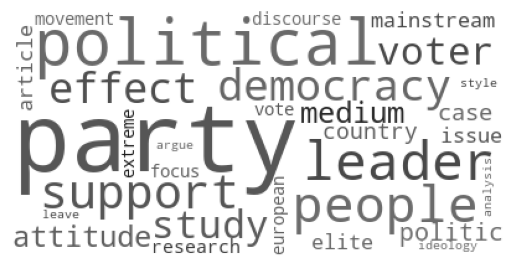

In [171]:
poptype = "right-wing"
subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
s = freqs_vals_weighted_df[poptype]
s_norm = s.apply(lambda x: ((x / s.max()) + 1) / 2)
wc = WordCloud(max_words=30, background_color="white", relative_scaling=0.5)
wc.generate_from_frequencies(get_freqs_vals(subset_df))
wc.recolor(color_func=image_colors)
plt.imshow(wc)  # , interpolation="bilinear")
plt.axis("off")
plt.show()

In [172]:
dict([el for el in get_freqs_vals(subset_df).items()][5:])

{'democracy': 0.006327305384332776,
 'effect': 0.006000734783851084,
 'study': 0.00506184430746622,
 'voter': 0.005021022982406009,
 'attitude': 0.00491896966975548,
 'medium': 0.0048781483446952685,
 'politic': 0.004816916357104952,
 'case': 0.004551577744213577,
 'country': 0.00449034575662326,
 'elite': 0.003939257868310405,
 'mainstream': 0.0038576152181899826,
 'issue': 0.003816793893129771,
 'article': 0.0037759725680695595,
 'research': 0.003571865942768502,
 'discourse': 0.003571865942768502,
 'extreme': 0.0034085806425276565,
 'vote': 0.003347348654937339,
 'european': 0.003286116667347022,
 'movement': 0.003286116667347022,
 'focus': 0.003224884679756705,
 'ideology': 0.003204474017226599,
 'analysis': 0.0031840633546964935,
 'style': 0.003143242029636282,
 'argue': 0.003122831367106176,
 'leave': 0.003122831367106176,
 'rhetoric': 0.0031024207045760705,
 'government': 0.003000367391925542,
 'different': 0.002979956729395436,
 'result': 0.0029187247418051188,
 'economic': 0.0

In [173]:
import nltk

In [174]:
to_remove = [tup[0] for tup in nltk.FreqDist([w for conc in concs_labeled_df["conc"] for w in conc]).most_common(5)]
to_remove

['party', 'political', 'people', 'democracy', 'politic']

In [175]:
subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
subset_df

conc        type  year  \
0     [access, use, find, print, homepage, cite, art...  right-wing  2011   
1     [access, use, find, print, homepage, cite, art...  right-wing  2011   
2     [view, view, relate, article, cite, article, v...  right-wing  2011   
3     [article, cite, article, view, cite, article, ...  right-wing  2011   
4     [success, study, test, assumption, compare, ef...  right-wing  2011   
...                                                 ...         ...   ...   
7889  [particular, time, period, dominate, argument,...  right-wing  2015   
7892  [post-material, value, propose, series, public...  right-wing  2015   
7893  [point, research, show, party, adopt, frame, p...  right-wing  2015   
7895  [differ, ideological, view, maybe, deserve, de...  right-wing  2015   
7908  [correct, vague, anxiety, new, perception, pol...  right-wing  2015   

                title  
0     Bos et al. 2011  
1     Bos et al. 2011  
2     Bos et al. 2011  
3     Bos et al. 2011  
4     Bos et al. 2011  
...               ...  
7889    Lindgren 2015  
7892    Lindgren 2015  
7893    Lindgren 2015  
7895    Lindgren 2015  
7908    Lindgren 2015  

[2736 rows x 4 columns]

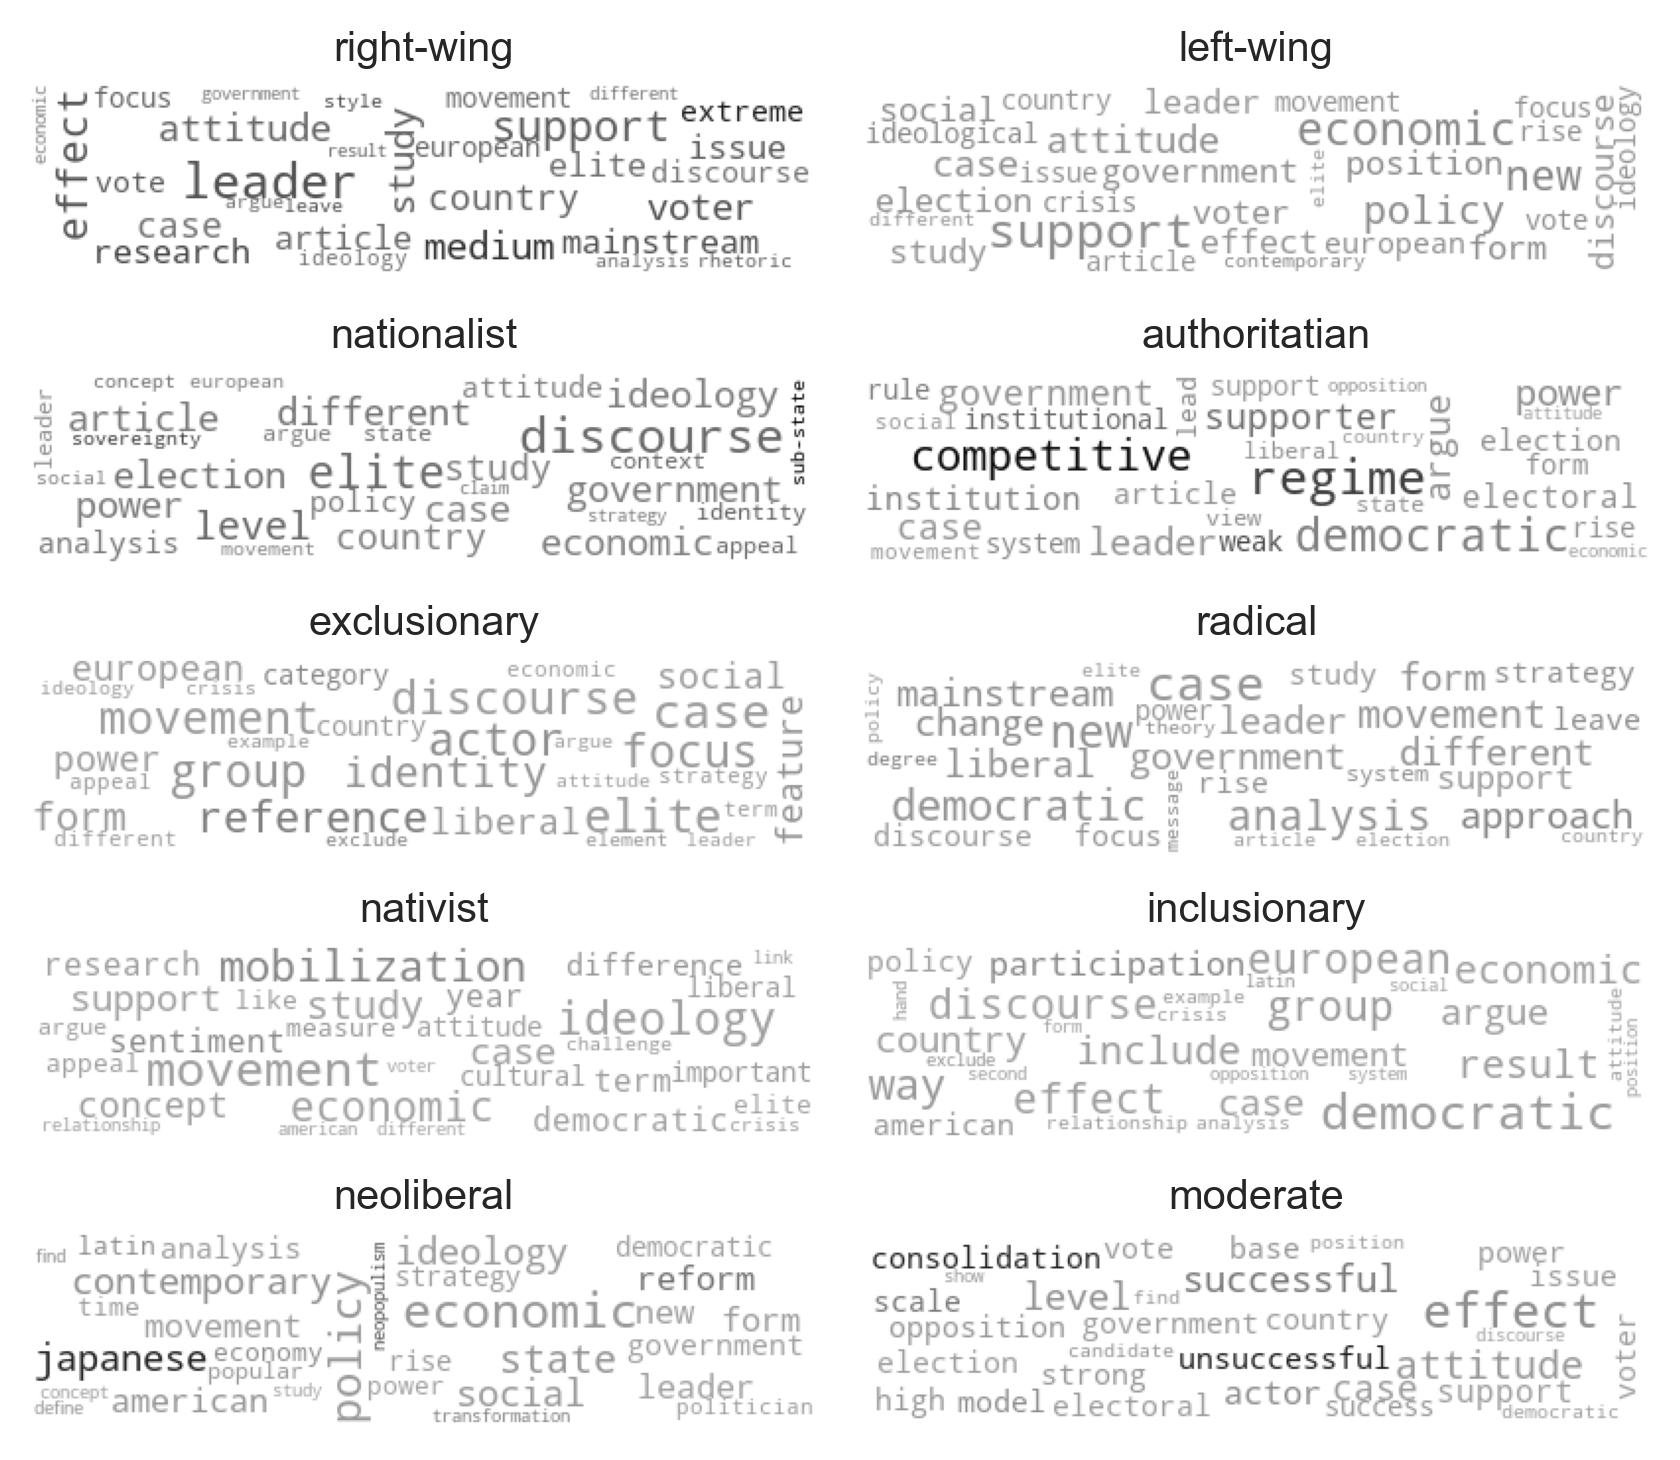

In [187]:
fig, axs = plt.subplots(5,2, figsize=(5.7,5), dpi=300,tight_layout=True)
for ax, poptype in zip(axs.ravel(), poptypes):
    subset_df = concs_labeled_df[concs_labeled_df["type"]==poptype]
    s = freqs_vals_weighted_df[poptype]
    s_norm = s.apply(lambda x: ((x / s.max()) + 0.8) / 1.8)
    wc = WordCloud(max_words=30, background_color="white", width=400, height=100, max_font_size=25)
    freqs = dict([el for el in get_freqs_vals(subset_df).items() if el[0] not in to_remove])
    wc.generate_from_frequencies(freqs)
    wc.recolor(color_func=image_colors)
    ax.imshow(wc) # , interpolation="bilinear")
    ax.axis("off")
    ax.set_title(poptype, size=10)

In [188]:
fig.savefig("../figures/wordcloud_v1.png")

In [198]:
weighted_cossim = pd.DataFrame(cosine_similarity(freqs_vals_weighted_df.T).round(2), columns=poptypes, index=poptypes)
weighted_cossim

right-wing  left-wing  nationalist  authoritatian  \
right-wing           1.00       0.10         0.14           0.09   
left-wing            0.10       1.00         0.08           0.06   
nationalist          0.14       0.08         1.00           0.08   
authoritatian        0.09       0.06         0.08           1.00   
exclusionary         0.07       0.04         0.06           0.04   
radical              0.09       0.06         0.08           0.05   
nativist             0.05       0.04         0.04           0.03   
inclusionary         0.05       0.04         0.05           0.04   
neoliberal           0.05       0.04         0.05           0.03   
moderate             0.06       0.03         0.04           0.03   

               exclusionary  radical  nativist  inclusionary  neoliberal  \
right-wing             0.07     0.09      0.05          0.05        0.05   
left-wing              0.04     0.06      0.04          0.04        0.04   
nationalist            0.06     0.08      0.04          0.05        0.05   
authoritatian          0.04     0.05      0.03          0.04        0.03   
exclusionary           1.00     0.04      0.02          0.03        0.02   
radical                0.04     1.00      0.03          0.04        0.04   
nativist               0.02     0.03      1.00          0.02        0.02   
inclusionary           0.03     0.04      0.02          1.00        0.02   
neoliberal             0.02     0.04      0.02          0.02        1.00   
moderate               0.02     0.03      0.02          0.03        0.01   

               moderate  
right-wing         0.06  
left-wing          0.03  
nationalist        0.04  
authoritatian      0.03  
exclusionary       0.02  
radical            0.03  
nativist           0.02  
inclusionary       0.03  
neoliberal         0.01  
moderate           1.00

<AxesSubplot: >

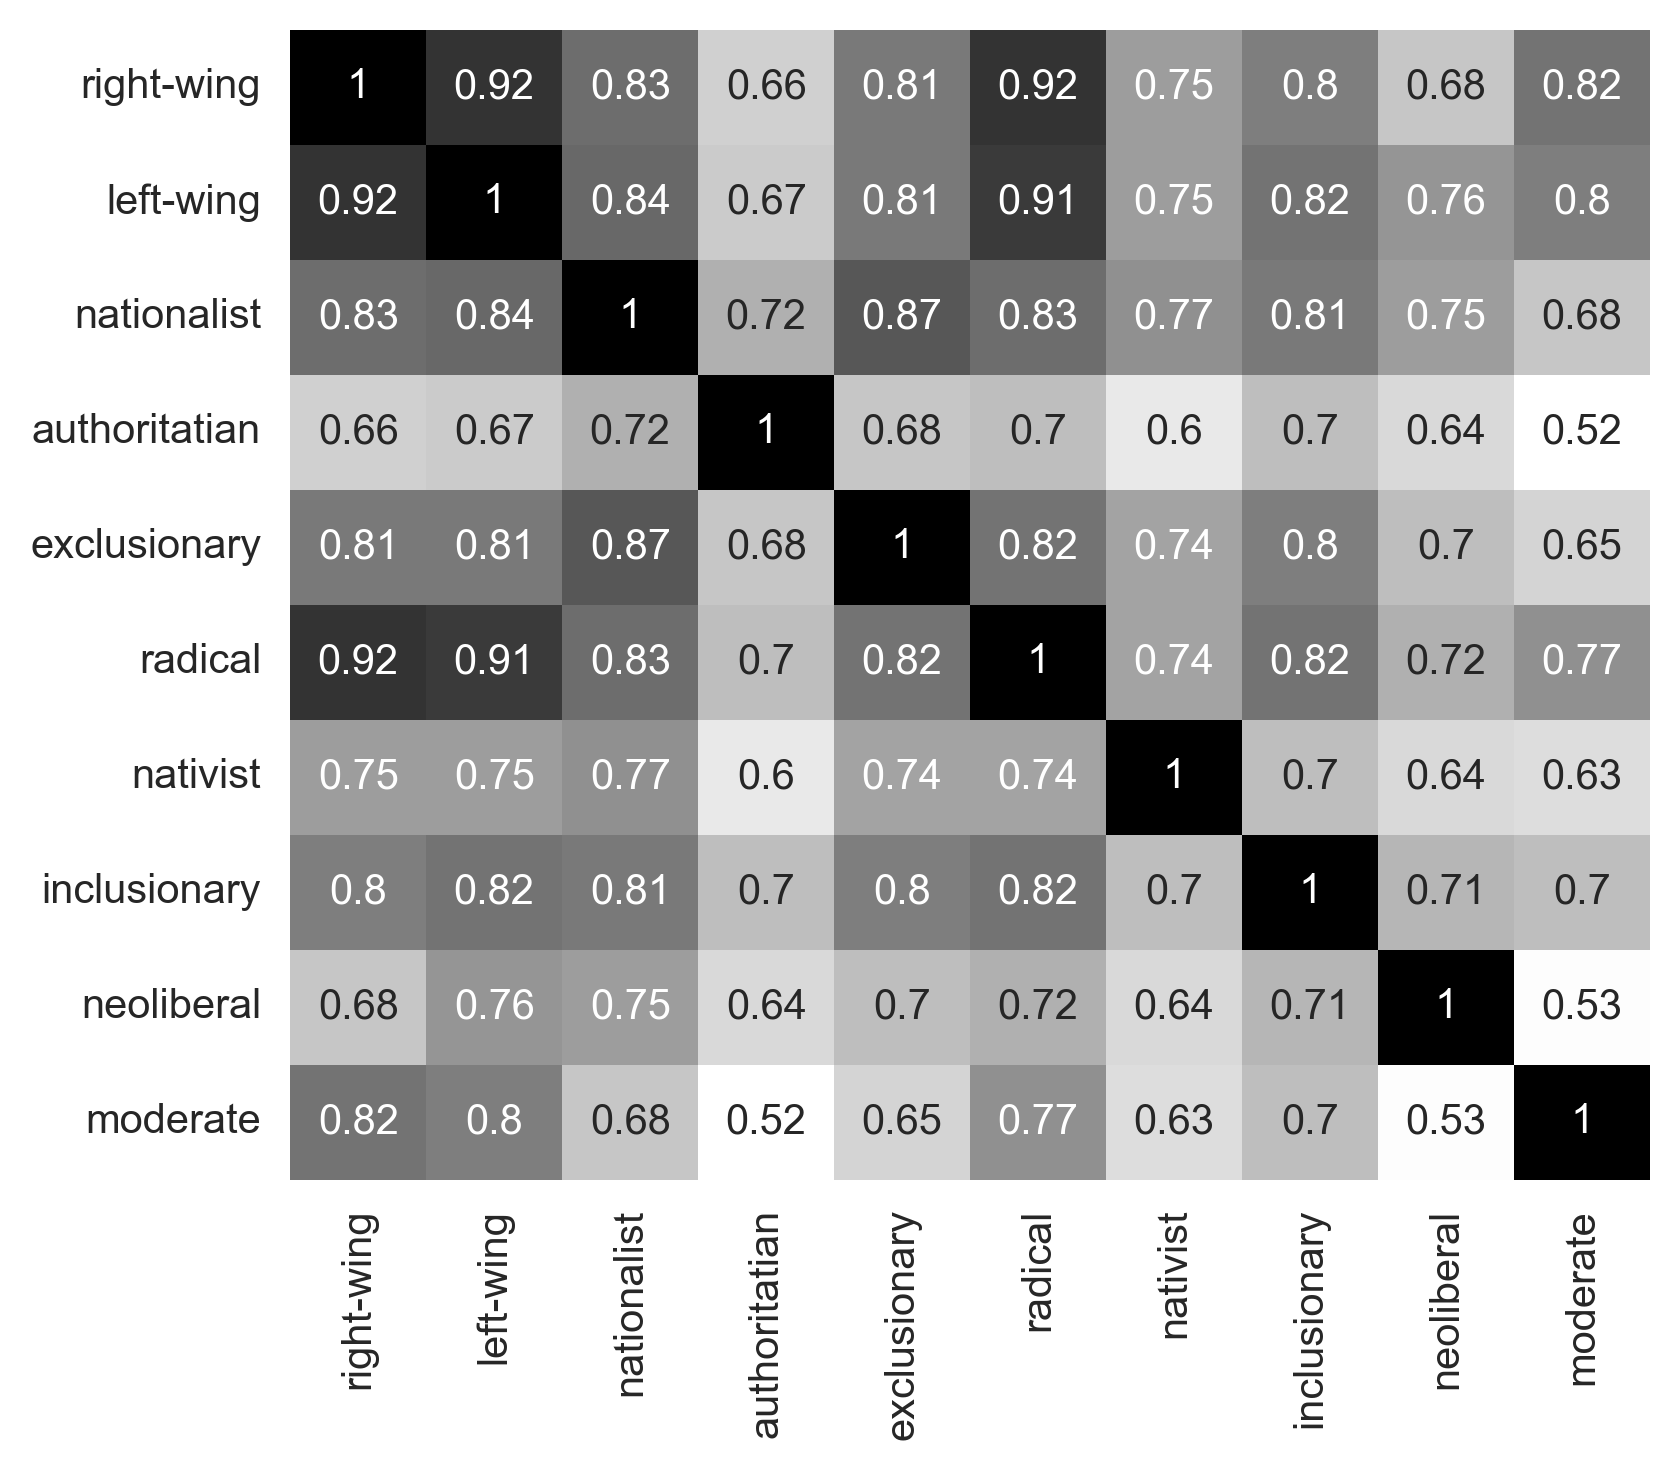

In [199]:
fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)
sns.heatmap(freqs_cossim, annot=True, cbar=None, cmap="Greys") #  , fmt='d', ax=ax)

<AxesSubplot: >

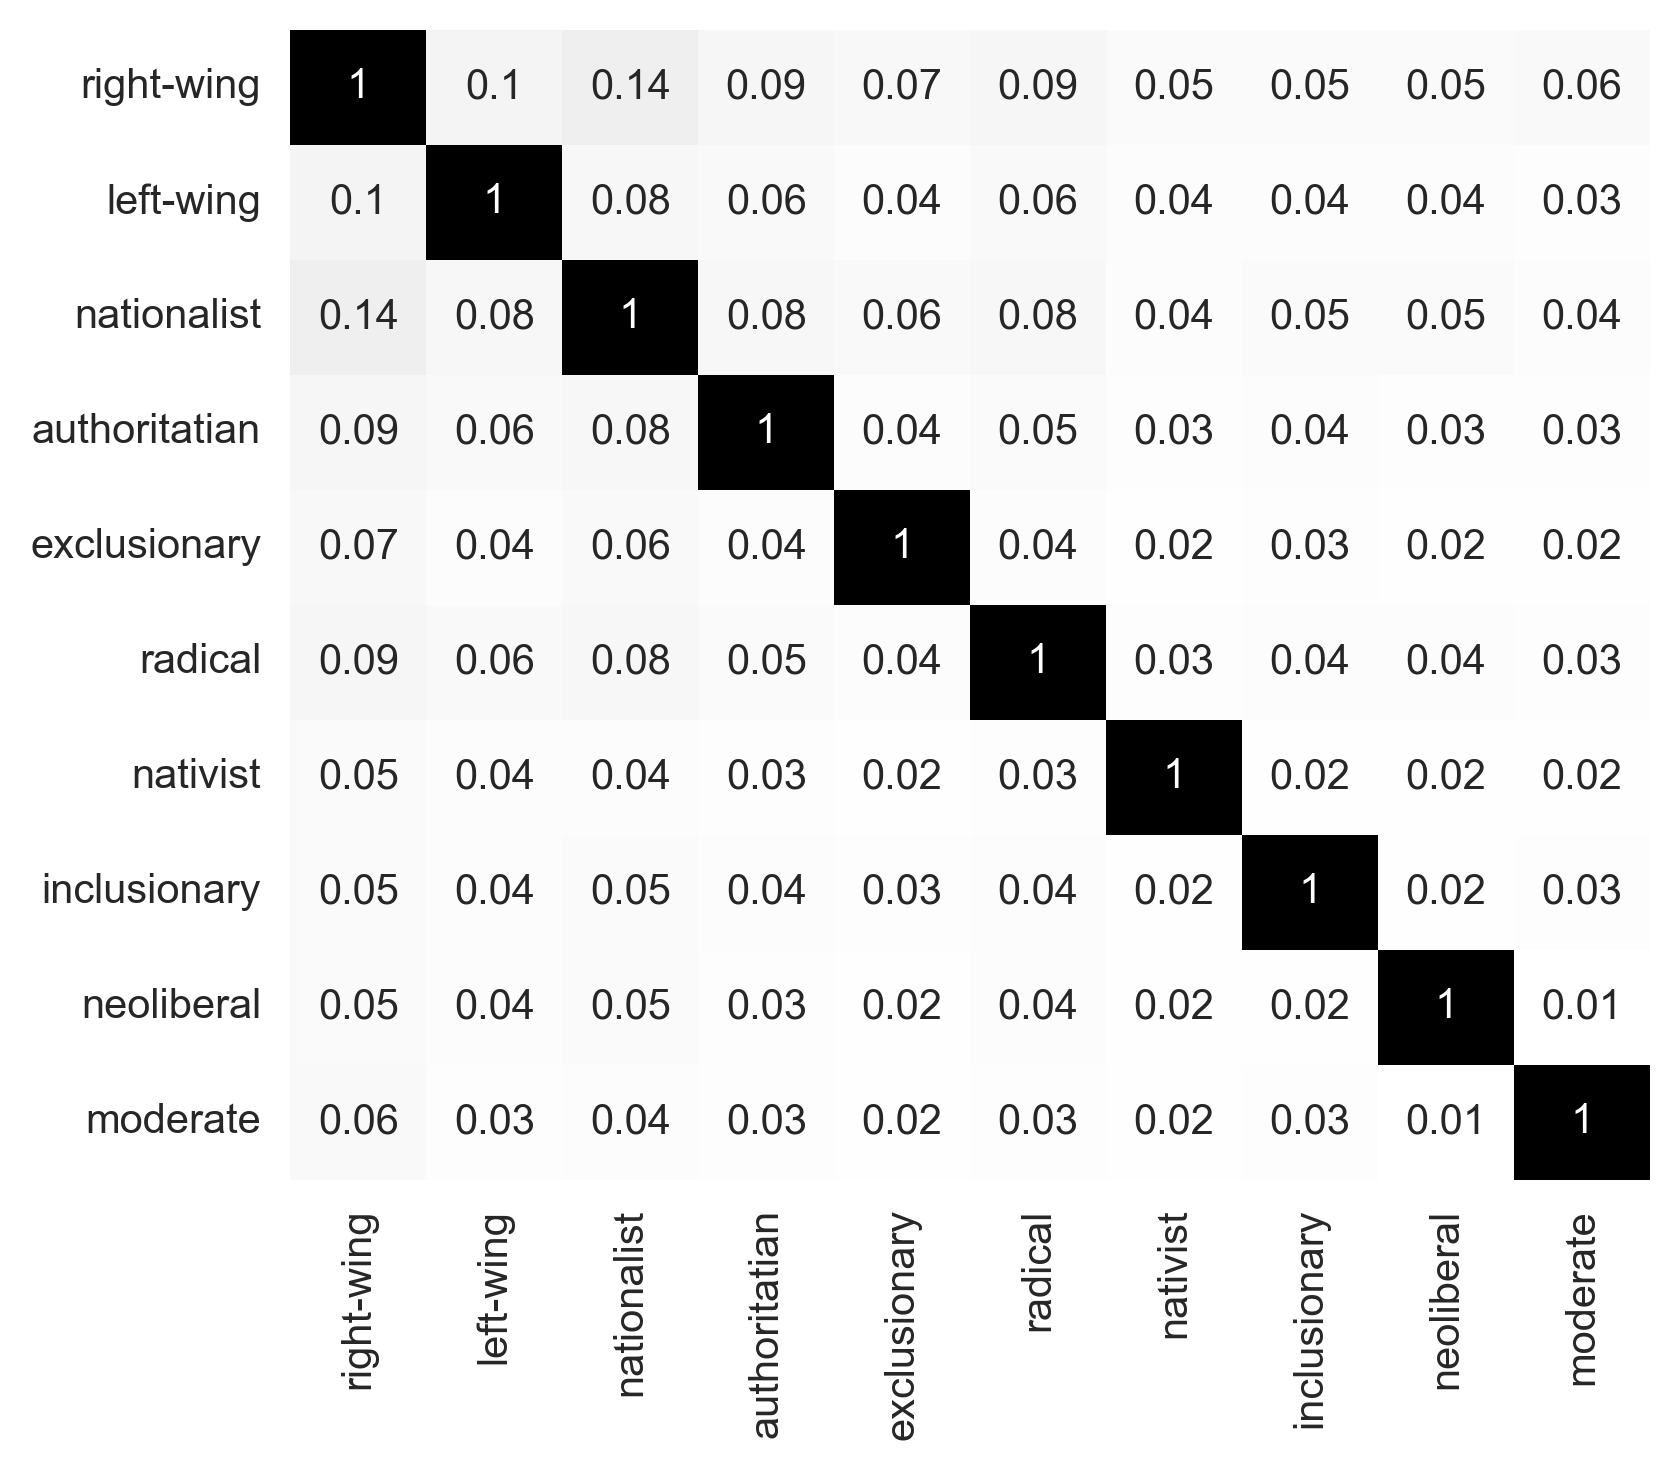

In [205]:
fig, ax = plt.subplots(figsize=(5.7, 5), dpi=300, tight_layout=True)
sns.heatmap(weighted_cossim, annot=True, cbar=None, cmap="Greys") #  , fmt='d', ax=ax)

In [206]:
fig.savefig("../figures/weighted_cossim.png")

<AxesSubplot: >

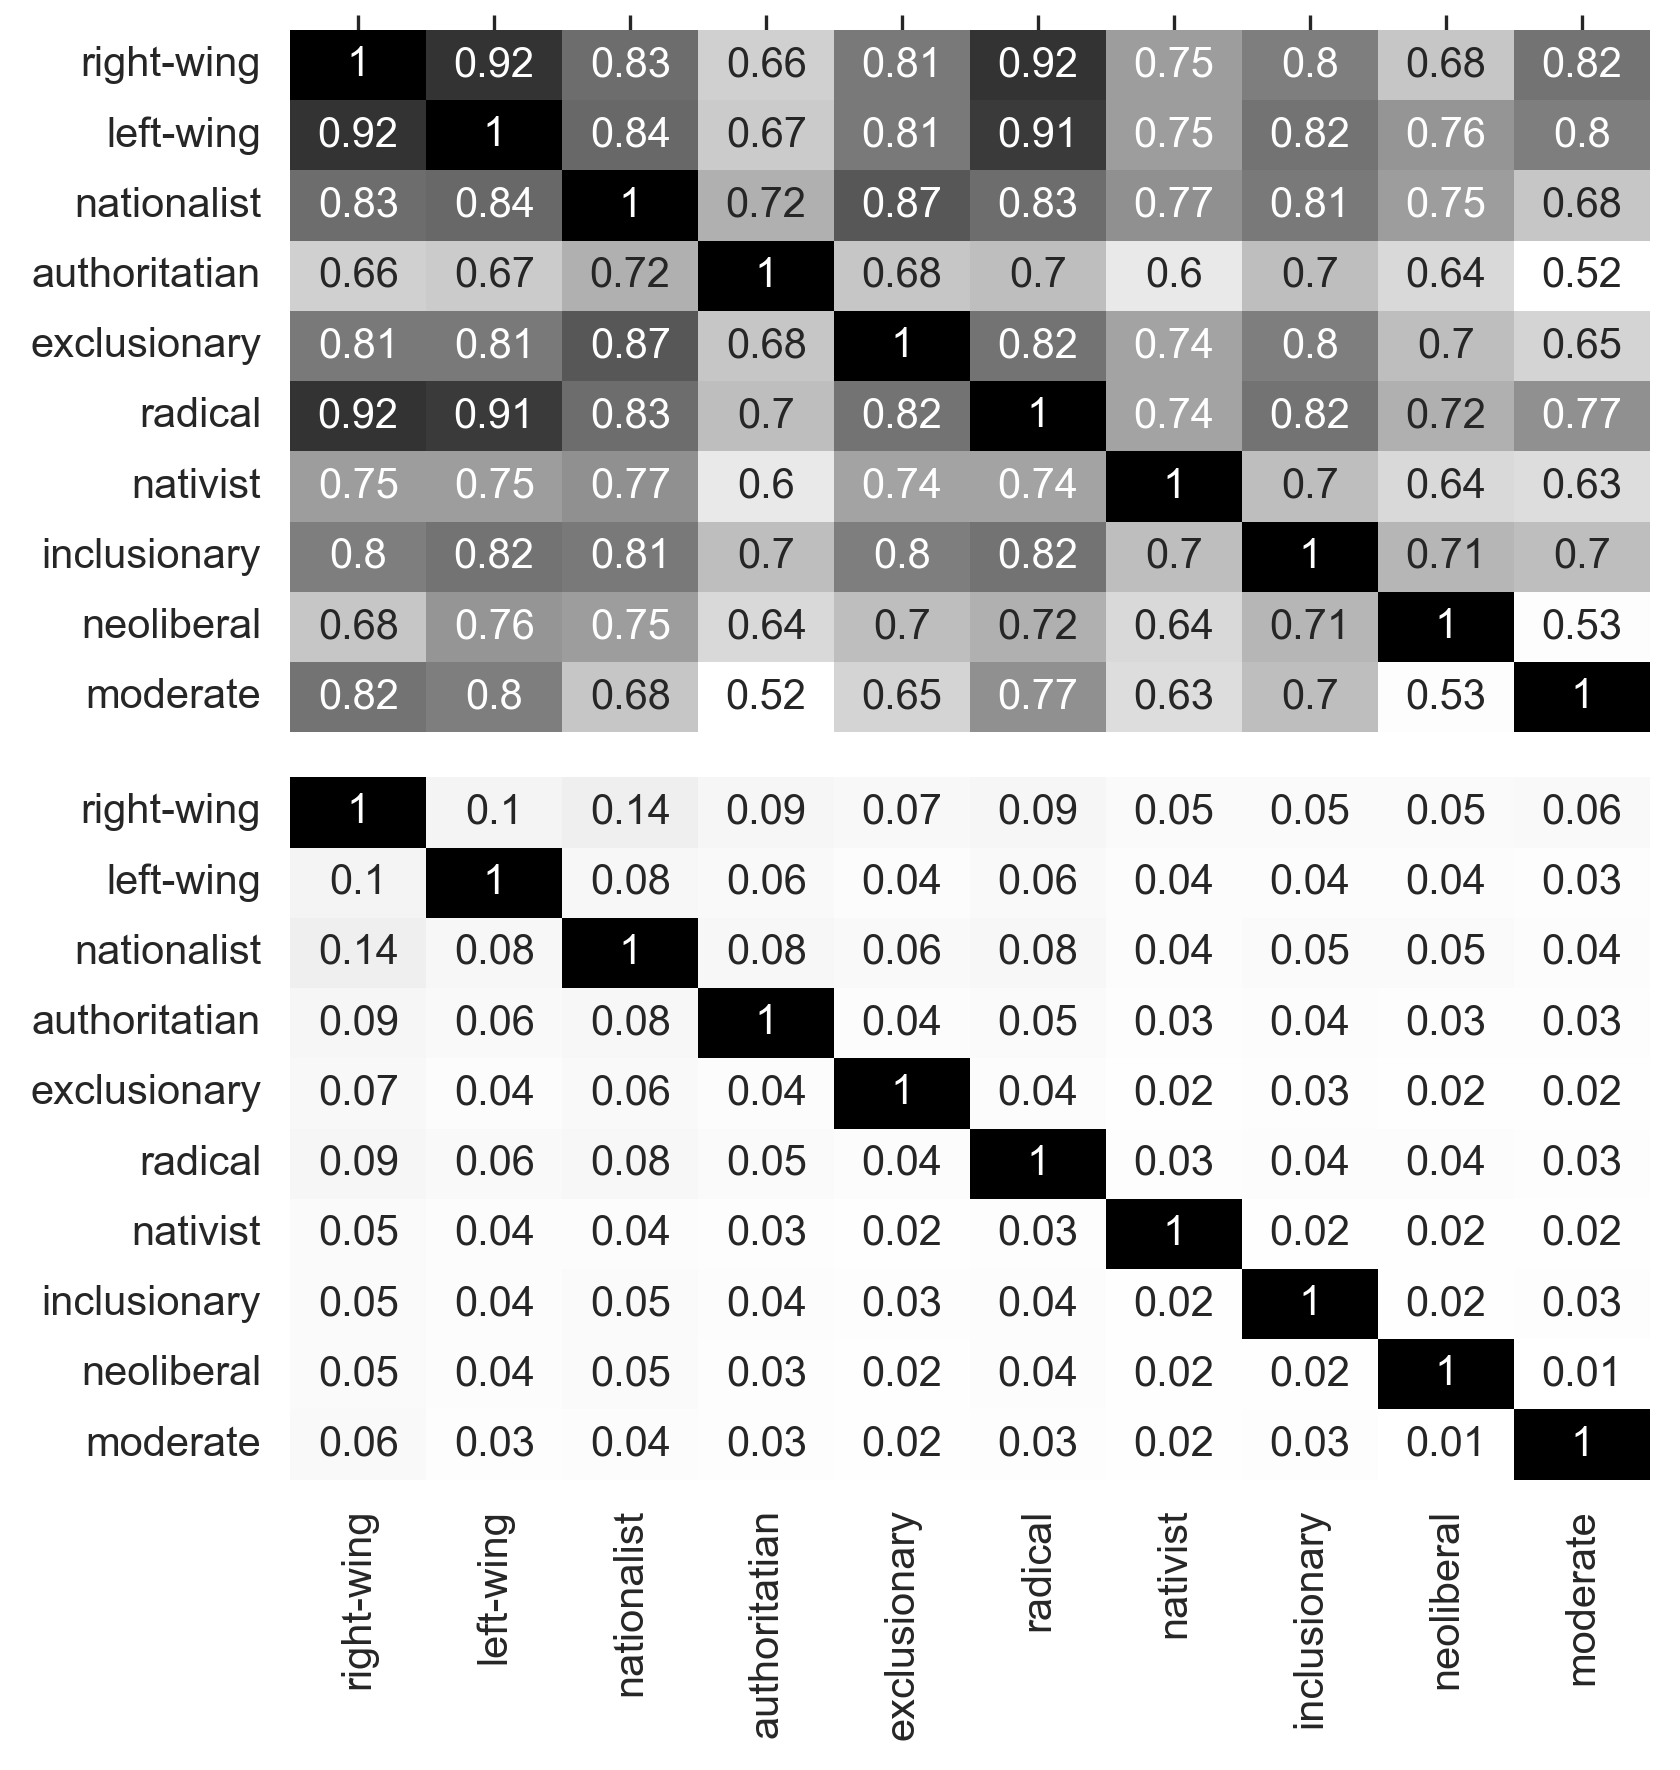

In [207]:
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(5.7, 6), dpi=300, tight_layout=True)
sns.heatmap(freqs_cossim, annot=True, cbar=None, cmap="Greys", ax=ax1)#  , fmt='d', ax=ax)
ax1.set_xticklabels([])
ax1.xaxis.set_ticks_position('top') # the rest is the same
sns.heatmap(weighted_cossim, annot=True, cbar=None, cmap="Greys", ax=ax2) #  , fmt='d', ax=ax)

In [208]:
fig.savefig("../figures/freqs_vs_weighted_cossim.png")

In [189]:
freqs_vals_weighted_df

right-wing  left-wing  nationalist  authoritatian  exclusionary  \
party           1.354859   1.142774     0.621188       0.379213      0.784595   
political       0.950847   0.975117     0.953457       1.049806      1.265444   
people          0.904766   0.649275     1.504469       0.660208      1.632571   
democracy       1.019875   0.677548     0.574002       2.605368      0.890266   
politic         0.822140   0.890621     1.330188       1.100578      1.044601   
...                  ...        ...          ...            ...           ...   
demobilizing    0.000000   0.000000     4.169916       0.000000      0.000000   
tacit           0.000000   0.000000     4.169916       0.000000      0.000000   
colonel         0.000000   0.000000     4.169916       0.000000      0.000000   
pueblo          0.000000   0.000000     4.169916       0.000000      0.000000   
backstoppe      0.000000   0.000000     0.000000       0.000000      0.000000   

               radical  nativist  inclusionary  neoliberal   moderate  
party         1.351600  0.681253      0.806633    0.582005   1.512321  
political     1.218389  0.617788      1.213269    1.351228   0.671825  
people        0.753088  1.026891      0.922898    0.358226   0.476072  
democracy     1.617912  0.569060      0.937625    0.389938   0.549624  
politic       1.104761  0.351498      0.857450    1.538989   0.232795  
...                ...       ...           ...         ...        ...  
demobilizing  0.000000  0.000000      0.000000    0.000000   0.000000  
tacit         0.000000  0.000000      0.000000    0.000000   0.000000  
colonel       0.000000  0.000000      0.000000    0.000000   0.000000  
pueblo        0.000000  0.000000      0.000000    0.000000   0.000000  
backstoppe    0.000000  0.000000      0.000000    0.000000  32.474913  

[9724 rows x 10 columns]

In [191]:
weighted_by_type_dict = {}
for poptype in poptypes:
    weighted_by_type_dict[poptype] = list(freqs_vals_weighted_df.sort_values(poptype, ascending=False).index[:100])
weighted_by_type_df = pd.DataFrame(weighted_by_type_dict)
weighted_by_type_df

right-wing                                          left-wing  \
0                   fifth                                         dissatisfy   
1                prisoner                                        anti-racist   
2           mainstreaming                                           contract   
3             parenthesis                                             fealty   
4           conspicuously                                         conﬂicting   
5                 unowned                                        expropriate   
6                  postal                                     re-nationalize   
7         disrespectfully                                   radical-populist   
8            non-european                                          publicize   
9       disproportionally                                  right-libertarian   
10               quadrant                                     burden-sharing   
11                    für                                      class-related   
12            heroisation                                            shatter   
13                 asylum                                            instill   
14               district                                             breech   
15                oppress                                         outrageous   
16            inefﬁciency                                     aggressiveness   
17                 camera                                   demonopolisation   
18          inexperienced                                        tribunitian   
19                 theses                                        mid-western   
20                     cr                                          signatory   
21              preoccupy                                      renegotiation   
22                     eR                                     women-friendly   
23            humiliation                                        twentyfirst   
24                 pincer                                         patriarchy   
25           oligarchical                                      unambiguously   
26                 forbid                                             vessel   
27          bureaucratism                                                ame   
28               lambaste                                             string   
29              privateer                                      irrationality   
30              cutthroat                                          distanced   
31                  imbed                                             bereft   
32              epitomize                                         wellspring   
33                cursory                                        destination   
34             prowelfare                                             delink   
35                 coddle                                          hamstring   
36                  stock                                          powerless   
37          24-hour-cycle                                          commenter   
38              wellbeing                                     right-populism   
39             profession                                           recovery   
40               eligible                                         outﬂanking   
41                bracket                                          quiescent   
42                  dalit                                          congruous   
43       english-language                                     policy-related   
44                   ical                                  radicaldemocratic   
45                    lag  http://creativetimereports.org/2012/11/15/occu...   
46         self-described                                               hark   
47                   orgy                                             ﬁfteen   
48              repossess                                     interpretative   
49             

In [192]:
google_conf.set_with_dataframe(pop_data.add_worksheet("weighted_by_type_df", 1,1), weighted_by_type_df)

In [193]:
weighted_by_type_df.to_csv("../data/weighted_by_type_df.csv")

# Narrow type approach

In [194]:
concs_covered_types_preceding = []
for conc, year, title in all_concs:
    type = ""
    if len(conc) == 21:
        for key in poptypes_dict.keys():
            if conc[9] in poptypes_dict[key]:
                type = key
    concs_covered_types_preceding.append((conc, type, year, title))

In [195]:
concs_covered_types_preceding_df = pd.DataFrame(concs_covered_types_preceding, columns=["conc", "type", "year", "title"])
concs_covered_types_preceding_df = concs_covered_types_preceding_df[concs_covered_types_preceding_df["type"]!=""]
len(concs_covered_types_preceding_df)

3598

In [196]:
concs_covered_types_preceding_df.groupby("type").size()

type
authoritatian     156
exclusionary      115
inclusionary       65
left-wing         649
moderate           44
nationalist       255
nativist           73
neoliberal         65
radical           111
right-wing       2065
dtype: int64